In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.sparse as sp

In [2]:
# Define constants for a typical coax transmission line
L =  0.14e-6 # inductance per unit length (H/m)
C = 80.3e-12 # capacitance per unit length (F/m)
R = 2.08e-3 # resistance per unit length (Ohm/m)
G = 0 # conductance per unit length (S/m)

In [3]:
# Calculation of transmission line parameters
Z0 = np.sqrt(L / C)  # characteristic impedance (Ohm)
print(f"Characteristic Impedance (Z0): {Z0:.2f} Ohm")
# Calculate the propagation velocity
v = 1 / np.sqrt(L * C)  # propagation velocity (m/s)
print(f"Propagation Velocity (v): {v:.2f} m/s")

Characteristic Impedance (Z0): 41.75 Ohm
Propagation Velocity (v): 298248459.76 m/s


In [4]:
line_length = 20e-6
dz = 5e-9 # dz
N_cells = int(line_length/dz) # jmax
print(f"The domain is discretized into {N_cells} cells")

The domain is discretized into 4000 cells


In [5]:
dt = dz/v # time step (s)
simulation_time = 1e-13
N_time = int(simulation_time/dt)
print(f"The simulation is run for {N_time} time steps")
print(f"Time step (dt): {dt:.2e} s")

The simulation is run for 5964 time steps
Time step (dt): 1.68e-17 s


In [6]:
state = np.zeros(N_cells * 2) # State vector consisting of alternating Ex and Hz
print(f"state vector shape: {state.shape}")

state vector shape: (8000,)


In [7]:
# Make sub arrays for state space analysis
# See paper for more details on the derivation of the state space model
Gm = (1 - dt*G/C) * np.eye(N_cells)
Rm = (1 - dt*R/L) * np.eye(N_cells)
# Gm = np.eye(N_cells)
# Rm = np.eye(N_cells)

Cm = np.zeros((N_cells, N_cells))
for i in range(1, N_cells):
    Cm[i, i-1] = -1
    Cm[i, i] = 1

Cm = dt / (C * dz) * Cm

Lm = np.zeros((N_cells, N_cells))
for i in range(0, N_cells-1):
    Lm[i, i+1] = 1
    Lm[i, i] = -1

Lm = dt / (L * dz) * Lm

print(Cm.shape)
print(Lm.shape)
print(Gm.shape)
print(Rm.shape)

(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)


In [8]:
# Naive approach with simple Eulers method
scale_dt = 1e3
Ad_euler = np.block([[Gm, Cm], [Lm, Rm]])
# Make a new matrix with scaled dt for demonstration purposes
Ad_euler_scaled = ((Ad_euler - np.eye(2 * N_cells)) / scale_dt) + np.eye(2 * N_cells)

# Convert to sparse matrix for faster computation
Ad_euler = sp.csr_matrix(Ad_euler)
Ad_euler_scaled = sp.csr_matrix(Ad_euler_scaled)

print(f"matrix shape: {Ad_euler.shape}")

matrix shape: (8000, 8000)


In [ ]:
def run_simulation(Ad, state, N_time, save_every=100, source = lambda t: 1):
    "Run a simulation with a given state space matrix"
    V_movie = []
    for n in range(N_time):
        # Update state vector
        state = Ad @ state

        # add source (for now just a step function)
        state[0] = source(n * dt)

        # Save the electric field
        if n % save_every == 0:
            V = state[0:N_cells]
            # print(f"step: {n})")
            # print(np.min(V),np.max(V))
            V_movie.append(V)
    return V_movie

In [10]:
# Run simulation with naive forward Euler method
# Reset state vector
state = np.zeros(N_cells * 2) # State vector consisting of alternating Ex and Hz
euler_movie = run_simulation(Ad_euler_scaled, state, N_time * int(scale_dt), save_every=int(100*scale_dt))
print(f"euler_movie shape: {np.array(euler_movie).shape}")

euler_movie shape: (60, 4000)


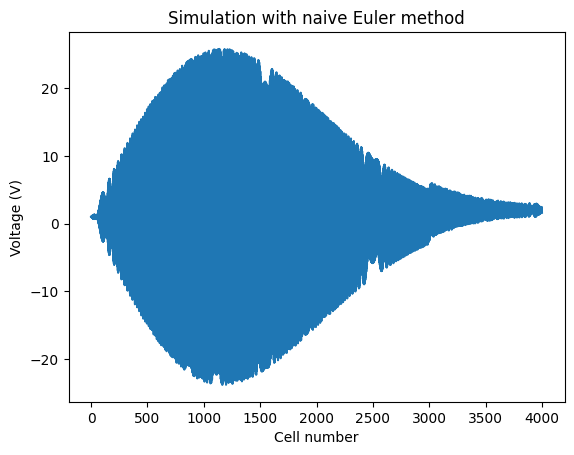

In [11]:
plt.plot(euler_movie[50])
plt.title("Simulation with naive Euler method")
plt.xlabel("Cell number")
plt.ylabel("Voltage (V)")
plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


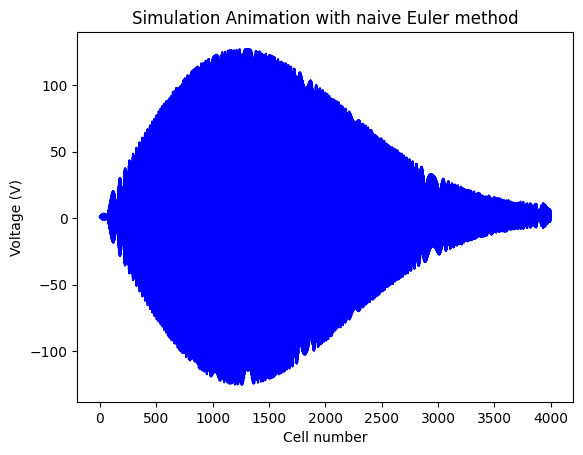

In [12]:
frames = [] # for storing the generated images
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(len(euler_movie)):
    im, = ax.plot(euler_movie[i],color = 'blue')
    frames.append([im])
ani = animation.ArtistAnimation(fig, frames, interval=20, blit=True,
                                repeat_delay=1000)

# plt.show()
plt.title("Simulation Animation with naive Euler method")
plt.xlabel("Cell number")
plt.ylabel("Voltage (V)")
ani.save('euler.gif', writer='imagemagick', fps=30)

In [13]:
# Use the Yee discretization in time
Ad_yee = np.block([[Gm + Cm @ Lm, Cm @ Rm], [Lm, Rm]])

# Convert to sparse matrix for faster computation
Ad_yee = sp.csr_matrix(Ad_yee)

print(f"matrix shape: {Ad_yee.shape}")

matrix shape: (8000, 8000)


In [14]:
# Run simulation with yee discretization
# Reset state vector
state = np.zeros(N_cells * 2) # State vector consisting of alternating Ex and Hz
yee_movie = run_simulation(Ad_yee, state, N_time)

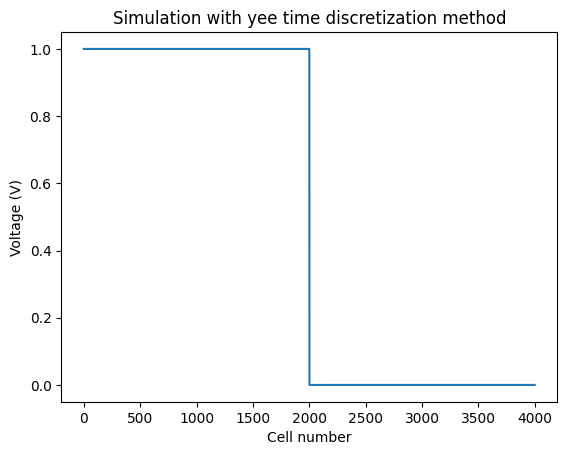

In [15]:
plt.plot(yee_movie[20])
plt.title("Simulation with yee time discretization method")
plt.xlabel("Cell number")
plt.ylabel("Voltage (V)")
plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


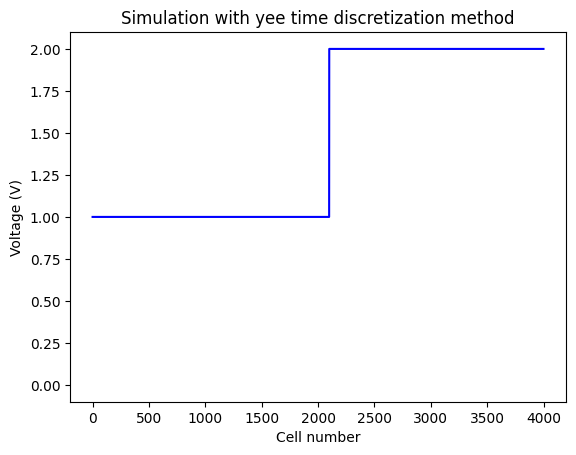

In [16]:
frames = [] # for storing the generated images
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(len(yee_movie)):
    im, = ax.plot(yee_movie[i],color = 'blue')
    frames.append([im])
ani = animation.ArtistAnimation(fig, frames, interval=20, blit=True,
                                repeat_delay=1000)


plt.title("Simulation with yee time discretization method")
plt.xlabel("Cell number")
plt.ylabel("Voltage (V)")
# plt.show()
ani.save('yee.gif', writer='imagemagick', fps=30)

In [17]:
Ad_euler = np.array(Ad_euler.todense())
Ad_euler_scaled = np.array(Ad_euler_scaled.todense())
Ad_yee = np.array(Ad_yee.todense())

eigvals_euler, _ = np.linalg.eig(Ad_euler)
eigvals_yee, _ = np.linalg.eig(Ad_yee)
eigvals_euler_scaled, _ = np.linalg.eig(Ad_euler_scaled)

In [18]:
# Sort eigenvalues in descending order
eigvals_euler = np.sort(eigvals_euler)[::-1]
eigvals_yee = np.sort(eigvals_yee)[::-1]
eigvals_euler_scaled = np.sort(eigvals_euler_scaled)[::-1]

In [19]:
# Print first 10 eigenvalues
print("Eigenvalues of Euler matrix:")
for i in range(10):
    print(f"Eigenvalue {i}: mag: {np.abs(eigvals_euler[i])} angle: {np.angle(eigvals_euler[i])}")
print("===========================")
print("Eigenvalues of Yee matrix:")
for i in range(10):
    print(f"Eigenvalue {i}: mag: {np.abs(eigvals_yee[i])} angle: {np.angle(eigvals_yee[i])}")


Eigenvalues of Euler matrix:
Eigenvalue 0: mag: 1.908685509861771 angle: 1.0193487454823402
Eigenvalue 1: mag: 1.908685509861771 angle: -1.0193487454823402
Eigenvalue 2: mag: 1.6443185318583764 angle: 0.9170624315746728
Eigenvalue 3: mag: 1.6443185318583764 angle: -0.9170624315746728
Eigenvalue 4: mag: 1.1974374353318773 angle: 0.5824514211265115
Eigenvalue 5: mag: 1.1974374353318773 angle: -0.5824514211265115
Eigenvalue 6: mag: 1.9928680868081552 angle: 1.0451301419874828
Eigenvalue 7: mag: 1.9403851982098923 angle: 1.029366792932062
Eigenvalue 8: mag: 1.9403851982098923 angle: -1.029366792932062
Eigenvalue 9: mag: 1.9928680868081552 angle: -1.0451301419874828
Eigenvalues of Yee matrix:
Eigenvalue 0: mag: 1.0 angle: 0.0
Eigenvalue 1: mag: 0.999999999999751 angle: 0.0
Eigenvalue 2: mag: 0.999999999999886 angle: 0.00039274817522138965
Eigenvalue 3: mag: 0.999999999999886 angle: -0.00039274817522138965
Eigenvalue 4: mag: 0.9999999999998801 angle: 0.0011782445256658637
Eigenvalue 5: mag: 

Text(0.5, 1.0, 'Eigenvalues of the State Space Matrices')

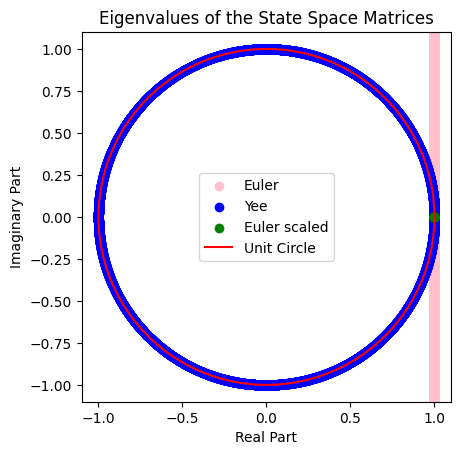

In [20]:
# Plot eigenvalues
plt.figure()
plt.scatter(np.real(eigvals_euler), np.imag(eigvals_euler), color='pink', label='Euler')
plt.scatter(np.real(eigvals_yee), np.imag(eigvals_yee), color='blue', label='Yee')
plt.scatter(np.real(eigvals_euler_scaled), np.imag(eigvals_euler_scaled), color='green', label='Euler scaled')

# Draw unit circle
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'red', label='Unit Circle')

# Set aspect ratio and limits so the unit circle isn't stretched
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.legend()
plt.title('Eigenvalues of the State Space Matrices')
# plt.legend("Eigenvalues Euler", "Eigenvalues Yee")